In [1]:
# General scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import matplotlib.gridspec as gridspec
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd
import time
from string import ascii_lowercase
from scipy import signal
from scipy import special
from scipy import integrate
from scipy.special import roots_legendre, eval_legendre
from scipy.constants import mu_0, epsilon_0
# Machine Epssilon for float
import ipywidgets
import time
from PIL import Image
import os
eps = np.finfo(float).eps

In [2]:
# Specific Geophysics libraries
import empymod
#from emip1d import DeepSeaTEMIP1D as empymodipinv
# SimPEG, discretize/
import discretize
from discretize import utils
from simpeg.electromagnetics import time_domain as tdem
from simpeg.electromagnetics import resistivity as dc
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from geoana.em.tdem import diffusion_distance
from geoana.em.tdem import peak_time
from pymatsolver import Pardiso

In [3]:
from masa_utils import TEM_Signal_Process
from masa_utils import TikonovInversion
from masa_utils import PsuedoLog

Simulatin and deep sea hydrothermal deposits explortaion using WISTEM (K. Nakayama and A. Saito, 2016) (K.Nakayama M. Motoori and A. Saito,2019).
This simulates the impact of pressure vessel in 2D cyrindrical simpegEMIP(S. Kang et al, 2015). SimPEG(R. Cockett et al, 2015), simpegEM(L. Heagy et al,2017). 
On-Time: 200msec
ramp time: 200usec
Transmitter Loop: 3.5m Square Loop
Receiver Loop: Coincident-type
Number of Turn: 5
3.5m rectangular loop has equivalent area for 2.0m circular. 
Pressure vessel 
Conductivity for metal: 1e6
Conductivity for air: 1e-8
height: 0.20
Width: 0.20
Thickness: 0.04

In [4]:
base_freq=1.25
on_time=0.2
rmp_time=200e-6
rec_time=0.2
smp_freq=50e3
time_step=1./smp_freq

In [5]:
tx_side = 3.5
tx_radius = (tx_side)/(np.sqrt(np.pi))
tx_circumerence = 2*np.pi*tx_radius
tx_area = np.pi*tx_radius**2
n_turns = 5
print(f"radius of transmitter: {tx_radius}")

radius of transmitter: 1.9746635424171473


In [6]:
sigma_air = 1e-8
sigma_sea = 3.0
sigma_seabed = 1.0
sigma_vessel = 1e6
thick_target = 30.
sigma_target = 1/0.15
frame_z = 0.2
height_vessel = 0.20
width_vessel = 0.20
thick_vessel = 0.04
tx_current = 1

In [7]:
csx1, csz1 = tx_radius/200., tx_radius/200.
ncsx1, ncsz1 = 50, 50 
padx1max, padz1max = 1.3, 1.3
csx2, csz2 = tx_radius/4.,tx_radius/4.
x2max, z2max =  50., 50
x2lim, z2lim = 2000, 2000
padx2max, padz2max = 1.3, 1.3

In [8]:
csx1, csz1 = tx_radius/200., tx_radius/200.
ncsx1, ncsz1 = 50, 50 

# csx1, csz1 = tx_radius/20., tx_radius/20.
# ncsx1, ncsz1 = 5, 5 
padx1max, padz1max = 1.3, 1.3
csx2, csz2 = tx_radius/4.,tx_radius/4.
x2max, z2max =  50., 50
x2lim, z2lim = 2000, 2000
padx2max, padz2max = 1.3, 1.3

In [9]:
from masa_utils import mesh_Pressure_Vessel
hx = mesh_Pressure_Vessel(tx_radius, csx1, ncsx1, padx1max, csx2, x2max, x2lim, padx2max)
hzneg = mesh_Pressure_Vessel(tx_radius, csz1, 1, padz1max, csz2, z2max, z2lim, padz2max)
hzpos = mesh_Pressure_Vessel(tx_radius, csz1, ncsz1, padz1max, csz2, z2max, z2lim, padz2max)
hz = np.r_[hzneg[::-1], hzpos]
mesh = discretize.CylindricalMesh([hx,1,hz], x0='00C')

In [10]:
np.save("70_hx.npy", hx)
np.save("70_hz.npy", hz)

In [11]:
tx_height = tx_radius/4.
print(tx_height)
radius_vessel = csx1*50.
thickness_vessel = csz1*5.
print(f"Vessel radius: {radius_vessel:.3f}, thickness: {thickness_vessel:.3f}")

0.4936658856042868
Vessel radius: 0.494, thickness: 0.049


In [12]:
def plot_vessel_outline(ax, lw=0.3):
    x_plot_out = width_vessel*np.r_[-1,1,1,-1,-1]
    y_plot_out = height_vessel*np.r_[1,1,0,0,1]  +frame_z 
    x_plot_in = (width_vessel-thick_vessel)*np.r_[-1,1,1,-1,-1]
    y_plot_in = (height_vessel-2*thick_vessel)*np.r_[1,1,0,0,1] + thick_vessel +frame_z 

    ax.plot(x_plot_out, y_plot_out, 'k-', lw=lw)
    ax.plot(x_plot_in, y_plot_in, 'k-', lw=lw)
    return ax

def plot_frame_outline(ax, lw=0.3):
    x_plot = width_frame*np.r_[-1,1,1,-1,-1]
    y_plot = height_frame*np.r_[1,1,0,0,1] 
    ax.plot(x_plot, y_plot, 'k-', lw=lw)
    return ax


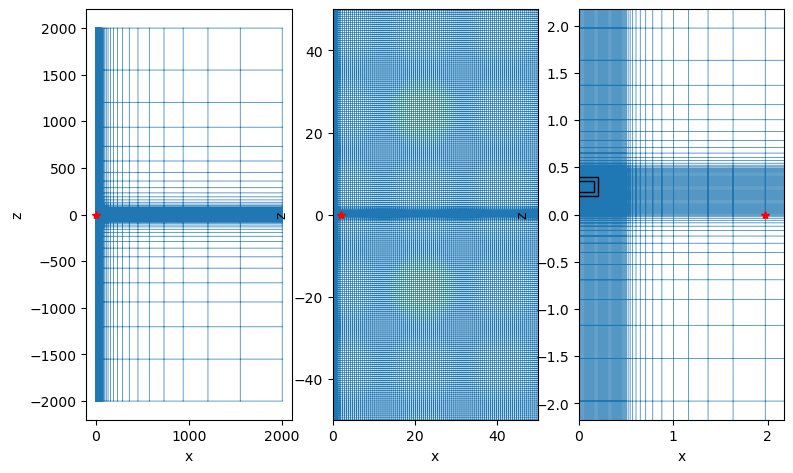

In [13]:
fig, ax = plt.subplots(1,3, figsize=(9,7))
ax[0] = mesh.plot_grid(ax=ax[0], show_it=False, linewidth=0.5)  
ax[1] =  mesh.plot_grid(ax=ax[1], show_it=False, linewidth=0.5)
ax[1].set_xlim(0.,x2max)
ax[1].set_ylim(-z2max , x2max )
ax[2] =  mesh.plot_grid(ax=ax[2], show_it=False, linewidth=0.5)
ax[2].set_xlim(0.,tx_radius*1.1)
ax[2].set_ylim(-tx_radius*1.1,tx_radius*1.1)
ax[2] = plot_vessel_outline(ax[2],lw=1.0)
for a in ax:
    a.set_aspect('equal')
    a.plot(tx_radius,0,'r*')
    a.grid(False)


## Set Up mapping

In [14]:


ind_container = (
    (mesh.cell_centers[:, 2] <= height_vessel + frame_z) &
    (mesh.cell_centers[:, 2] >= frame_z) &
    (mesh.cell_centers[:, 0] <= width_vessel)
)

ind_sea = (mesh.cell_centers[:, 2] > - tx_height) & ~ind_container
ind_active = ~ind_sea
ind_vessel = (
    (mesh.cell_centers[ind_active][:, 2] <= height_vessel + frame_z) &
    (mesh.cell_centers[ind_active][:, 2] >= frame_z) &
    (mesh.cell_centers[ind_active][:, 0] <= width_vessel)
)
ind_air = (
    (mesh.cell_centers[ind_active][:, 2] < height_vessel - thick_vessel + frame_z) &
    (mesh.cell_centers[ind_active][:, 2] > thick_vessel + frame_z) &
    (mesh.cell_centers[ind_active][:, 0] < width_vessel - thick_vessel)
)

ind_metal = ind_vessel &  ~ind_air
ind_layer = ((mesh.cell_centers[ind_active][:, 2] <= - tx_height) & 
            (mesh.cell_centers[ind_active][:, 2] > -( tx_height + thick_target)) )
ind_seabed = mesh.cell_centers[ind_active][:, 2] <= -( tx_height + thick_target)


In [15]:
print(mesh.n_cells)
print(ind_active.sum())
print(ind_vessel.sum())
print(ind_air.sum())
print(ind_metal.sum())
print(ind_layer.sum())
print(ind_seabed.sum())
assert ind_active.sum() == ind_air.sum() + ind_metal.sum() + ind_layer.sum() + ind_seabed.sum()


61664
24672
420
192
228
11844
12408


In [16]:
indices_list = [ind_metal, ind_air, ind_layer, ind_seabed]
active_map = maps.InjectActiveCells(mesh= mesh,
             active_cells=ind_active  , value_inactive=np.log(sigma_sea))
projection_map = maps.SurjectUnits(indices_list)
## Kill indices for the seawater

## Exponential map to convert the model to conductivity
exp_map = maps.ExpMap(mesh)
model_map = exp_map*active_map *  projection_map
#model_map = exp_map*active_map *  parametric_map

In [17]:
model_ref = np.log(np.r_[
    sigma_sea, sigma_sea, sigma_sea, sigma_sea ]
    )
model_target = np.log(np.r_[
    sigma_sea, sigma_sea, sigma_target, sigma_seabed]
    )
model_vessel = np.log(np.r_[
    sigma_vessel, sigma_air, sigma_sea, sigma_sea]
    )
model_vessel_target = np.log(np.r_[
    sigma_vessel, sigma_air, sigma_target, sigma_seabed]
    )



## time step and current
ramp time 200 $ \mu $ sec    
K. Nakayama, 2016, Practical marine TDEM systems using ROV for the ocean bottom hydrothermal deposits, Techno-Ocean Kobe, Japan, 2016


In [18]:
time_steps = [(2e-6,  150),  (5e-6,  150),  (2e-5,  150), (5e-5,  10)]
time_step_min = 2e-6
tstrt, tend = 1e-4, 4.0e-3
steps = np.array([])
for i in range(len(time_steps)):
    dt, n = time_steps[i]
    step_array = dt * np.ones(n)
    steps = np.concatenate((steps, step_array))
time_clc = np.cumsum(steps)
# since using step off waveform
rmp_time_sim = time_clc[0]
time_rec = time_clc[1:] -rmp_time_sim 
print(time_clc)
print(time_rec)

[2.000e-06 4.000e-06 6.000e-06 8.000e-06 1.000e-05 1.200e-05 1.400e-05
 1.600e-05 1.800e-05 2.000e-05 2.200e-05 2.400e-05 2.600e-05 2.800e-05
 3.000e-05 3.200e-05 3.400e-05 3.600e-05 3.800e-05 4.000e-05 4.200e-05
 4.400e-05 4.600e-05 4.800e-05 5.000e-05 5.200e-05 5.400e-05 5.600e-05
 5.800e-05 6.000e-05 6.200e-05 6.400e-05 6.600e-05 6.800e-05 7.000e-05
 7.200e-05 7.400e-05 7.600e-05 7.800e-05 8.000e-05 8.200e-05 8.400e-05
 8.600e-05 8.800e-05 9.000e-05 9.200e-05 9.400e-05 9.600e-05 9.800e-05
 1.000e-04 1.020e-04 1.040e-04 1.060e-04 1.080e-04 1.100e-04 1.120e-04
 1.140e-04 1.160e-04 1.180e-04 1.200e-04 1.220e-04 1.240e-04 1.260e-04
 1.280e-04 1.300e-04 1.320e-04 1.340e-04 1.360e-04 1.380e-04 1.400e-04
 1.420e-04 1.440e-04 1.460e-04 1.480e-04 1.500e-04 1.520e-04 1.540e-04
 1.560e-04 1.580e-04 1.600e-04 1.620e-04 1.640e-04 1.660e-04 1.680e-04
 1.700e-04 1.720e-04 1.740e-04 1.760e-04 1.780e-04 1.800e-04 1.820e-04
 1.840e-04 1.860e-04 1.880e-04 1.900e-04 1.920e-04 1.940e-04 1.960e-04
 1.980

## Waveform step off


In [19]:
# rmp_time = 200e-6
# waveform = tdem.sources.RampOffWaveform(off_time = rmp_time)
waveform=tdem.sources.StepOffWaveform()
# EMF is calculated as integration of E-field over the loop wire 
rx_x = tdem.receivers.PointElectricField(
    locations=np.r_[tx_radius, 0, 0 ], times=time_rec+time_clc[0] # time_rec
    , orientation="y"
)
src = tdem.sources.CircularLoop(
    location=np.r_[0, 0, 0], radius=tx_radius, receiver_list=[rx_x],
    waveform=waveform, n_turns=n_turns,
)
survey = tdem.Survey([src])
sim = tdem.simulation.Simulation3DElectricField(
    mesh=mesh, survey=survey,  solver=Pardiso, time_steps=time_steps,
    sigmaMap=model_map
)


[2.e-06 4.e-06 6.e-06]


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


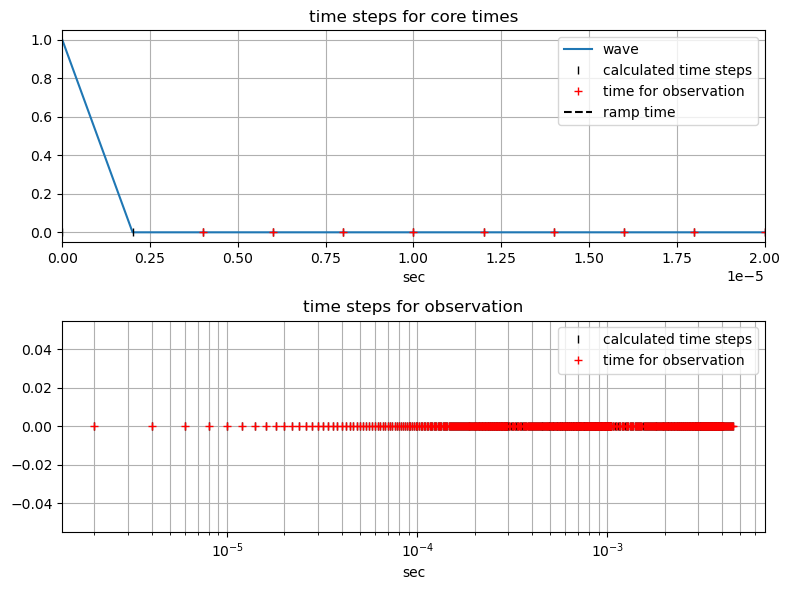

In [20]:
fig, ax = plt.subplots(2,1,figsize=(8,6))
ax[0].plot(sim.times, [waveform.eval(t) for t in sim.times],label='wave')
ax[0].plot(sim.times, np.zeros_like(sim.times), "|k",label='calculated time steps')
ax[0].plot(time_rec+time_clc[0], np.zeros_like(time_rec), "+r",lw=3,label='time for observation')
ax[0].axvline(rmp_time, color='k', linestyle='--',label='ramp time')
ax[0].set_xlim(0,20e-6)#time_steps[0][0]*time_steps[0][1])
ax[0].set_title('time steps for core times')

ax[1].semilogx(sim.times, np.zeros_like(sim.times), "|k",label='calculated time steps')
ax[1].semilogx(time_rec, np.zeros_like(time_rec), "+r",lw=3,label='time for observation')
ax[1].set_title('time steps for observation')
print(time_rec[:3])
for a in ax:
    a.grid(which='both')
    a.set_xlabel('sec')
    a.legend()
plt.tight_layout()
plt.show()

## Plot model

In [21]:
def plot_model(model, clim=[-8,6], xlim=[-3,3], ylim=[-3.,3], ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    # Plot the image and add a color bar
    img = mesh.plot_image(np.log10(model_map * model), clim=clim, ax=ax, mirror=True)[0]
    cb = plt.colorbar(img, ax=ax, shrink=1.4)  # Adjust the 'shrink' parameter to control height

    # Plot the source locations and earth surface
    ax.plot(np.r_[src.radius, -src.radius], 
            np.r_[src.location[2], src.location[2]], "ko-", markersize=3)
    
    # Format the color bar
    cb.set_label('$\log_{10}\sigma$')

    # Set axis limits and aspect ratio
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('z (m)')
    ax.grid(which='both', color='k', linestyle='-', linewidth=0.2)
  
    return ax


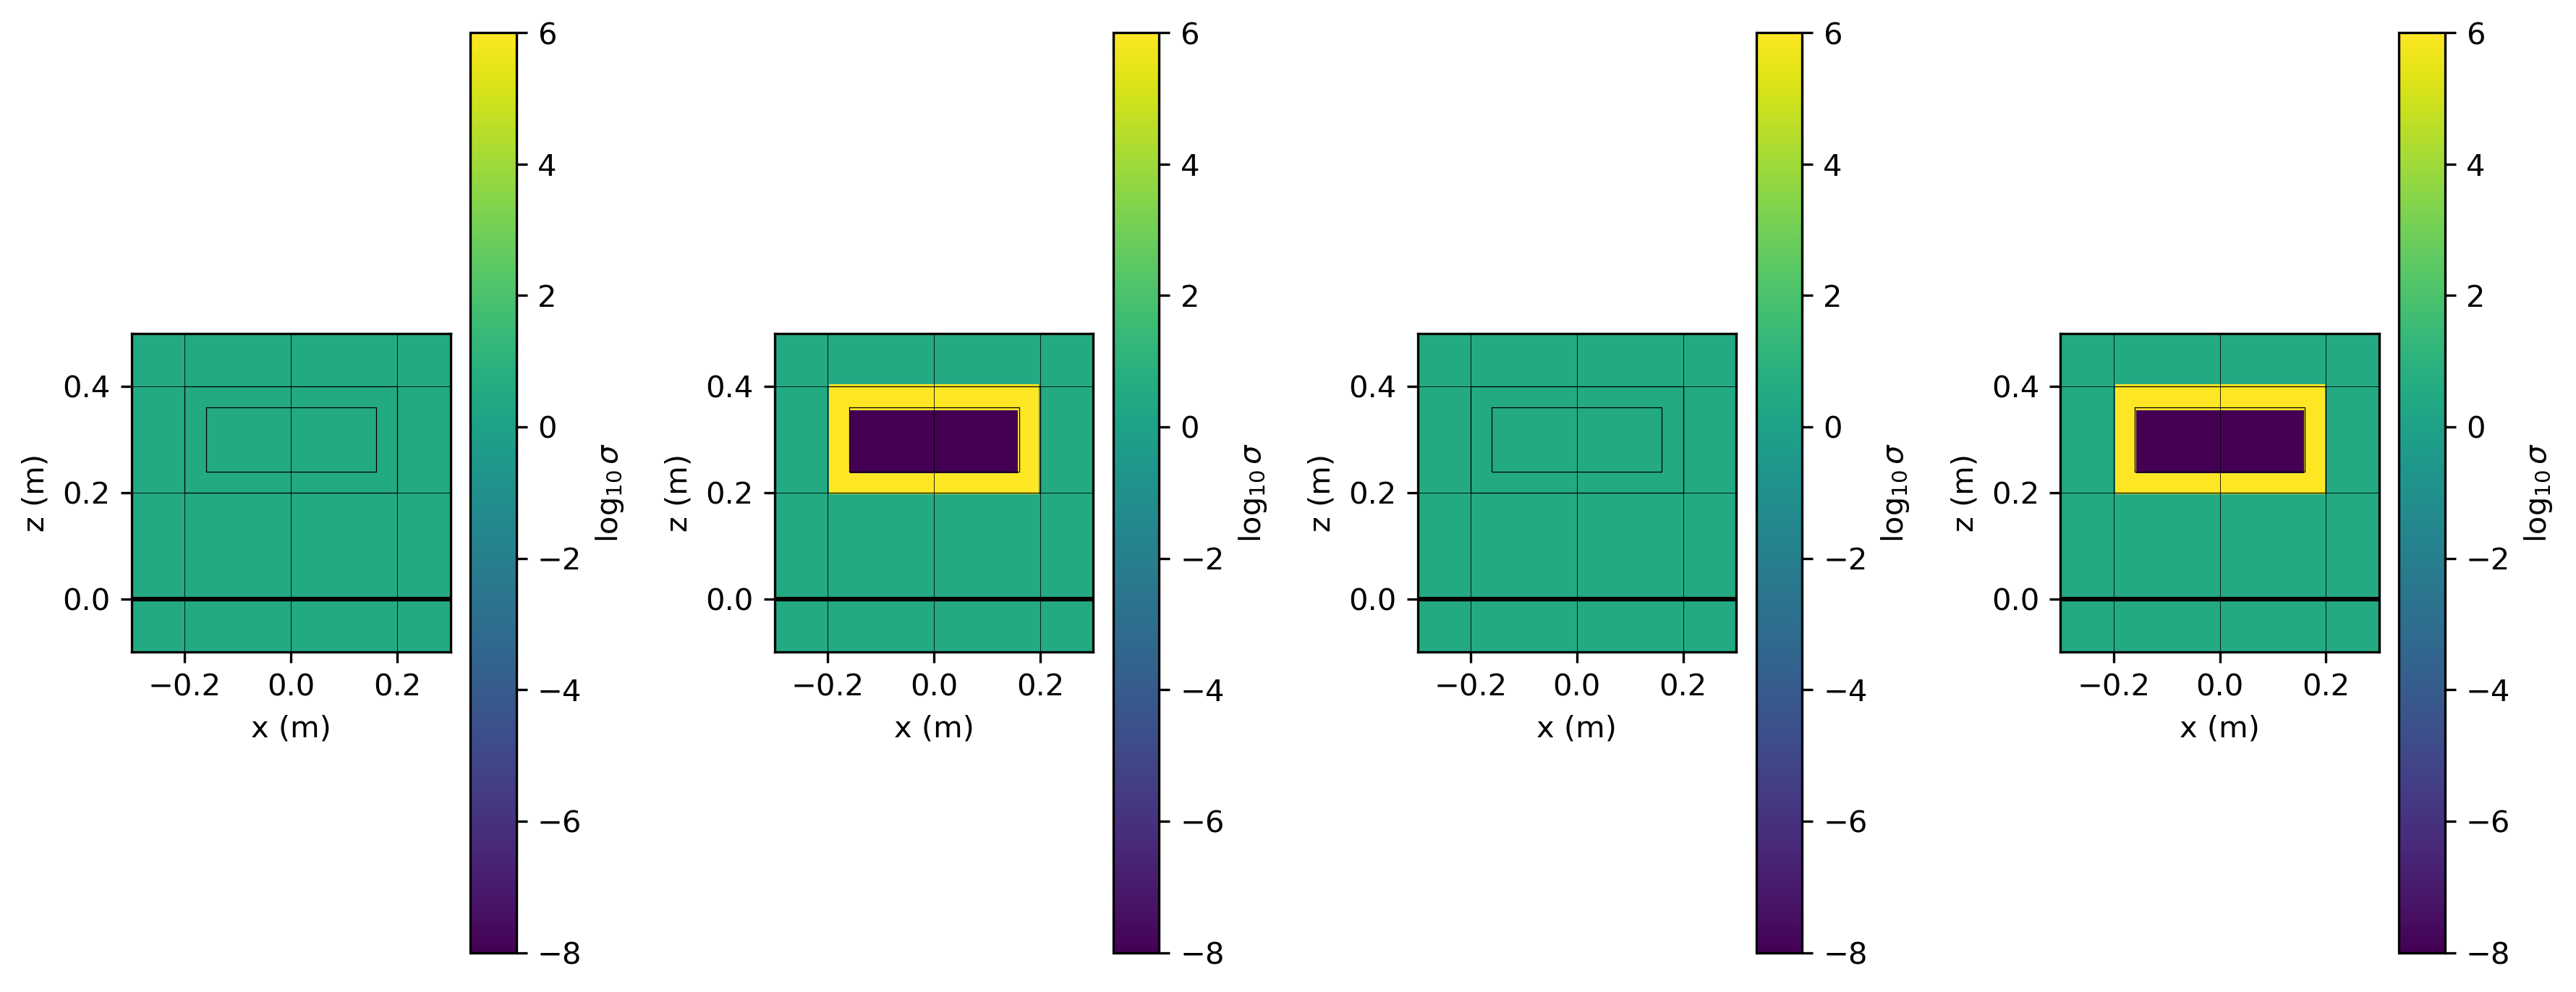

In [22]:
fig , ax = plt.subplots(1,4,figsize=(12,5), dpi=300)
ax = ax.flatten()
xlim, ylim = [-0.3, 0.3], [-0.1,0.5]
clim=[-8,6]
ax[0]=plot_model(model= model_ref, xlim=xlim,ylim=ylim,clim=clim, ax=ax[0])
ax[1]=plot_model(model= model_vessel, xlim=xlim,ylim=ylim,clim=clim, ax=ax[1])
ax[2]=plot_model(model= model_target, xlim=xlim,ylim=ylim,clim=clim,ax=ax[2])
ax[3]=plot_model(model= model_vessel_target, xlim=xlim,ylim=ylim,clim=clim, ax=ax[3])

for a in ax:
    plot_vessel_outline(ax=a)
plt.tight_layout()
# plt.savefig('72_models_vessel.png', dpi=300)

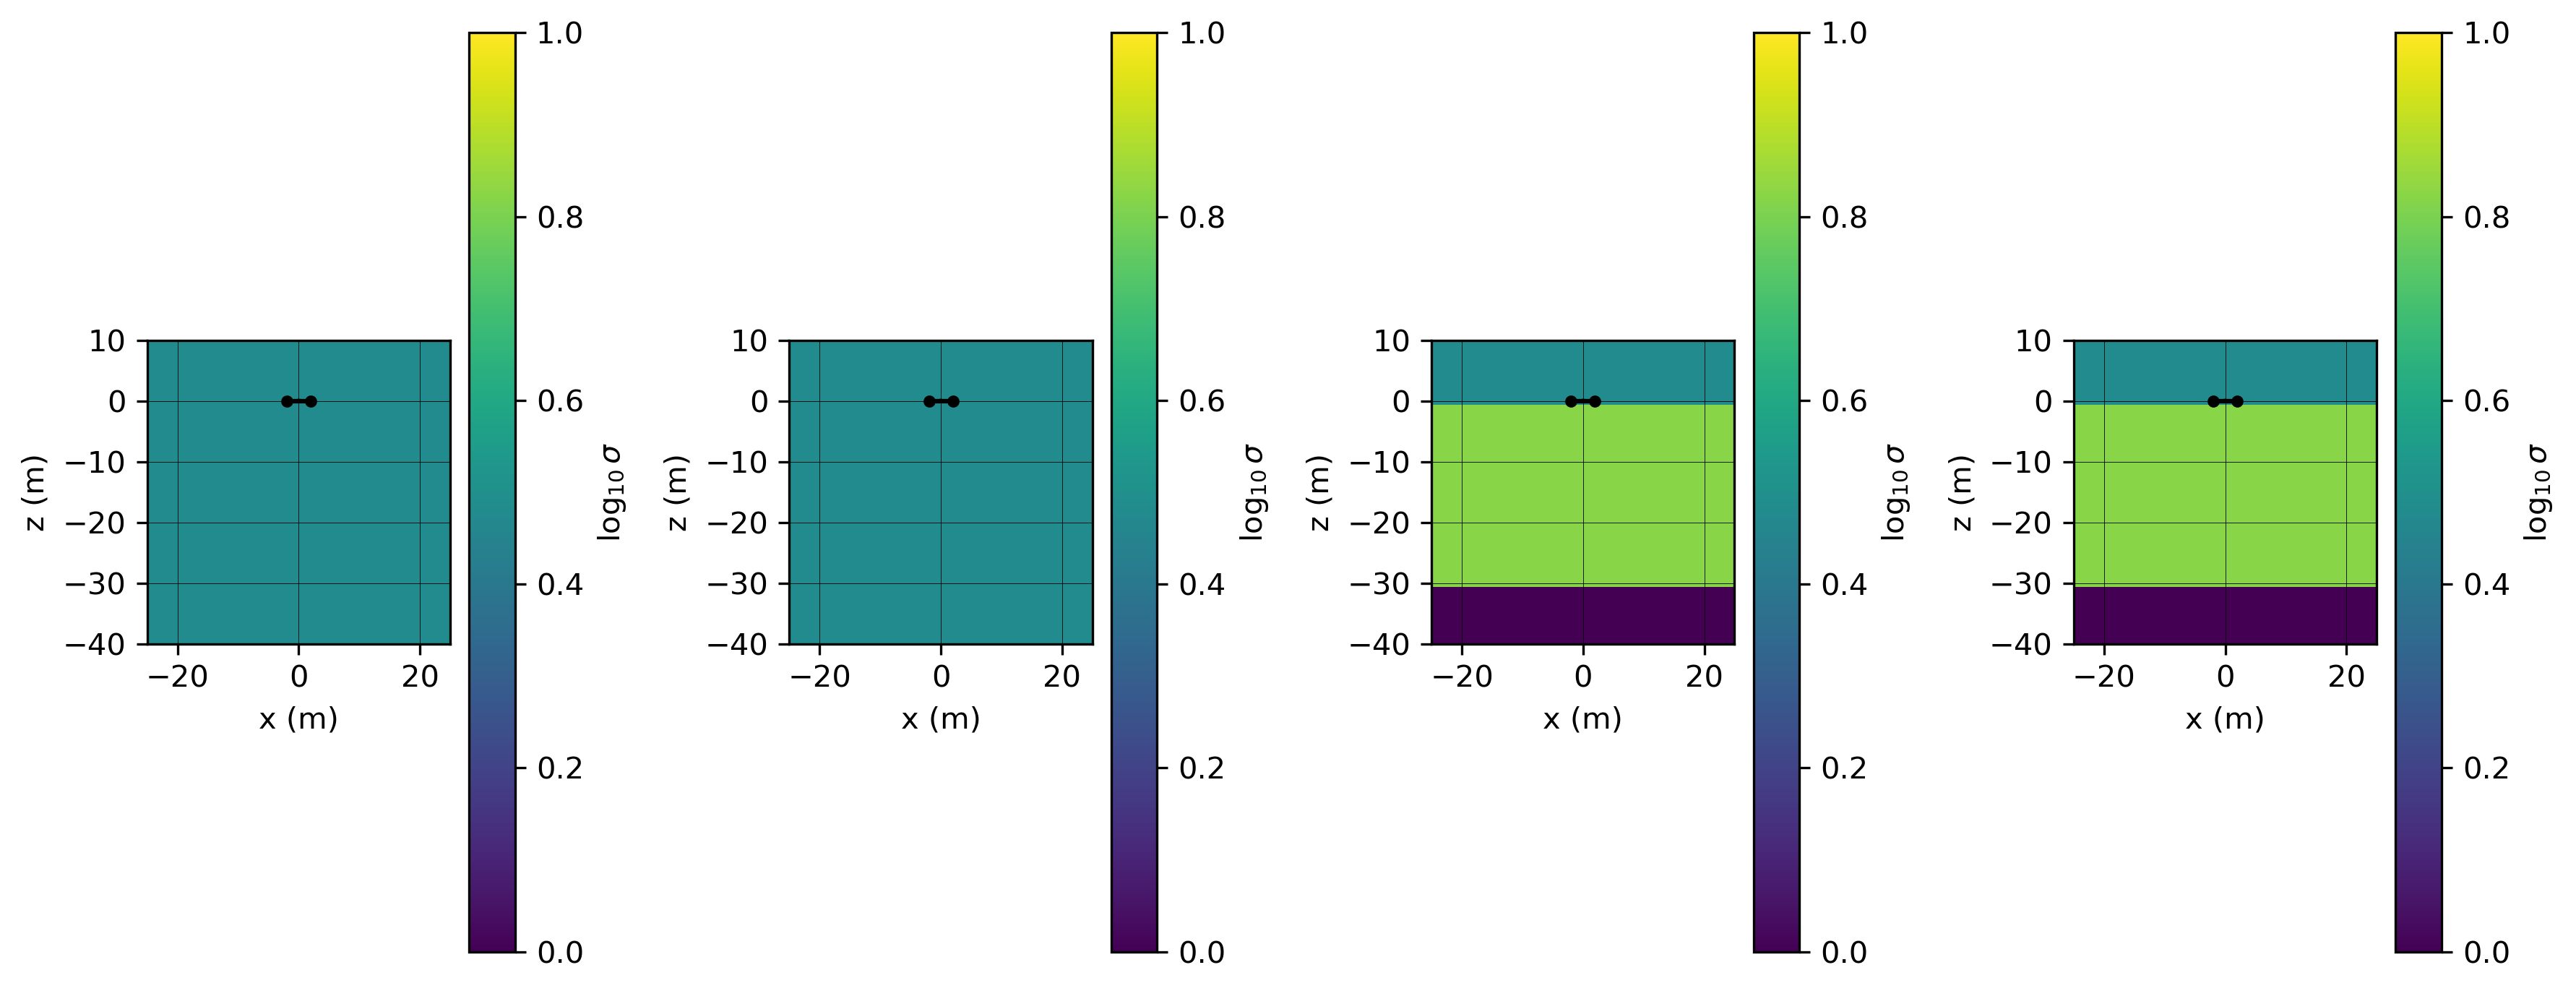

In [23]:
fig , ax = plt.subplots(1,4,figsize=(12,5), dpi=300)
ax = ax.flatten()
xlim, ylim = [-25, 25], [-40,10]
clim=[0,1]
ax[0]=plot_model(model= model_ref,    xlim=xlim,ylim=ylim,clim=clim, ax=ax[0])
ax[1]=plot_model(model= model_vessel, xlim=xlim,ylim=ylim,clim=clim, ax=ax[1])
ax[2]=plot_model(model= model_target, xlim=xlim,ylim=ylim,clim=clim, ax=ax[2])
ax[3]=plot_model(model= model_vessel_target, xlim=xlim,ylim=ylim,clim=clim, ax=ax[3])

for a in ax:
    plot_vessel_outline(ax=a)
plt.tight_layout()
# plt.savefig('72_models_layer.png', dpi=300)

# Simulation

In [24]:
## Simulation
fields_ref = sim.fields(model_ref)
sim_ref =sim.dpred(model_ref, f=fields_ref)
print(f"reference model done")
dpred_ref   = tx_circumerence*sim_ref

c:\Users\81805\anaconda3\envs\env_ubcgif\Lib\site-packages\geoana\spatial.py:128: RuntimeWarning: invalid value encountered in multiply
  vec[..., 0] * np.cos(grid[..., 1]) - vec[..., 1] * np.sin(grid[..., 1]),
c:\Users\81805\anaconda3\envs\env_ubcgif\Lib\site-packages\geoana\em\static\wholespace.py:629: RuntimeWarning: invalid value encountered in matmul
  A = rot.apply(A, inverse=True).reshape(xyz.shape)


reference model done


In [25]:

fields_vessel = sim.fields(model_vessel)
sim_vessel = sim.dpred(model_vessel, f=fields_vessel)
dpred_vessel = tx_circumerence*sim_vessel
print(f"vessel model done")

vessel model done


In [26]:
fields_target = sim.fields(model_target)
sim_target =sim.dpred(model_ref, f=fields_target)
print(f"reference model done")
dpred_target   = tx_circumerence*sim_target

c:\Users\81805\anaconda3\envs\env_ubcgif\Lib\site-packages\geoana\spatial.py:128: RuntimeWarning: invalid value encountered in multiply
  vec[..., 0] * np.cos(grid[..., 1]) - vec[..., 1] * np.sin(grid[..., 1]),
c:\Users\81805\anaconda3\envs\env_ubcgif\Lib\site-packages\geoana\em\static\wholespace.py:629: RuntimeWarning: invalid value encountered in matmul
  A = rot.apply(A, inverse=True).reshape(xyz.shape)


reference model done


In [27]:
fields_vessel_target = sim.fields(model_vessel_target)
sim_vessel_target =sim.dpred(model_ref, f=fields_vessel_target)
print(f"reference model done")
dpred_vessel_target   = tx_circumerence*sim_vessel_target

reference model done


# Road simpegEMIP data

In [28]:
# np_saved = np.load("73_Validation_simpegEMIP.npy")
# times_rec_simpegEMIP = np_saved[0,:]
# dpred_IP = np_saved[2,:]
np_saved = np.load("74_Pressure_vessel_LayerIP.npy")
times_rec_simpegEMIP = np_saved[0,:]
dpred_IP_vessel = np_saved[1,:]
dpred_IP = np_saved[2,:]
# fields_saved = np.load("14_fields_emip.npy")

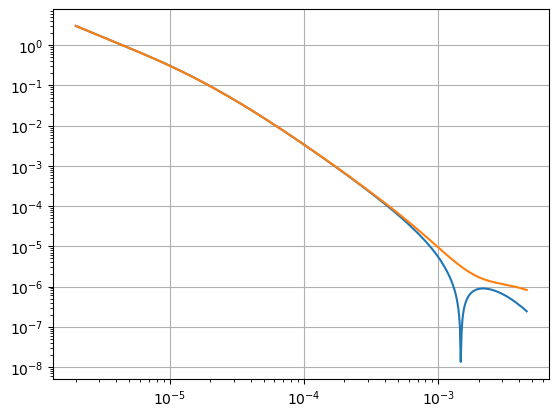

In [29]:
plt.loglog(times_rec_simpegEMIP,np.abs(dpred_IP))
plt.loglog(times_rec_simpegEMIP,np.abs(dpred_IP_vessel))
plt.grid()

# apply linearly cut off ramp

In [214]:
WISTEM_SP_sim = TEM_Signal_Process (
    # base_freq=base_freq,
    # on_time=on_time, 
    rmp_time=rmp_time, 
    rec_time=tend+1/smp_freq, 
    smp_freq= 1/time_step_min #  smp_freq*4
)  
print(1/time_step_min)
times_sim = WISTEM_SP_sim.times_rec
print(time_rec[:5], time_rec[-5:])
print(times_sim[:5], times_sim[-5:])


WISTEM_SP_dpred = TEM_Signal_Process(
    rmp_time=rmp_time,
    rec_time=tend,
    smp_freq =smp_freq
)
print(smp_freq)
times_rec = WISTEM_SP_dpred.times_rec
times_filt = WISTEM_SP_dpred.times_filt
filt_linrmp = WISTEM_SP_dpred.filter_linear_rmp()

# WISTEM_SP_sim.get_windows_cen(windows_cen=times_rec)
print(times_rec.size)
print(times_rec[:5])


print(filt_linrmp.size)

500000.0
[2.e-06 4.e-06 6.e-06 8.e-06 1.e-05] [0.004348 0.004398 0.004448 0.004498 0.004548]
[2.e-06 4.e-06 6.e-06 8.e-06 1.e-05] [0.004012 0.004014 0.004016 0.004018 0.00402 ]
50000.0
200
[2.e-05 4.e-05 6.e-05 8.e-05 1.e-04]
200


In [ ]:
# from scipy.signal import decimate

up=1
# down=4
down=int((1/time_step_min)//smp_freq)

# print(times_sim_shift[:5], times_sim_shift[-5:])
from scipy.signal import resample_poly, resample, decimate

10


In [227]:
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline, PchipInterpolator

In [228]:

def apply_lowpass_fiilter_time(data, f_in, cutoff,order=1):
    nyquist = 0.5 * f_in
    normal_cutoff = cutoff / nyquist
    b,a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return signal.filtfilt(b,a,data)

def downsample(data, down):
    n_in = data.size
    n_out = n_in // down
    downsampled = np.zeros(n_out)
    for i in range(n_out):
        downsampled[i] = np.mean(data[i*down:(i+1)*down]) 
    return downsampled[:n_out]

In [229]:
# f_in  = 500e3        # 500 kHz
# f_out = 50e3         # 50 kHz
# duration = 3e-3

# n_in  = int(duration * f_in)
# n_out = int(duration * f_out)

# times_in  = 1/f_out  + np.linspace(0, duration, n_in,endpoint=False)  # 2e-6, 4e-6, ...
# times_out = 1/f_out + np.linspace(0, duration, n_out,endpoint=False)  # 2e-5, 4e-5, ...

# # 補間
# interpolator = interp1d(time_rec, dpred_ref, kind='linear',
#                         bounds_error=False, fill_value="extrapolate")
# dpred_ref_interp = interpolator(times_in)

# plt.loglog(time_rec, dpred_ref, 'o-', label='original')
# plt.loglog(times_in, dpred_ref_interp, 'o-', label='interpolated')
# plt.legend()


(800,) (200,)
[2.0e-05 2.5e-05 3.0e-05 3.5e-05 4.0e-05] [0.003995 0.004    0.004005 0.00401  0.004015]
[2.e-05 4.e-05 6.e-05 8.e-05 1.e-04] [0.00392 0.00394 0.00396 0.00398 0.004  ]


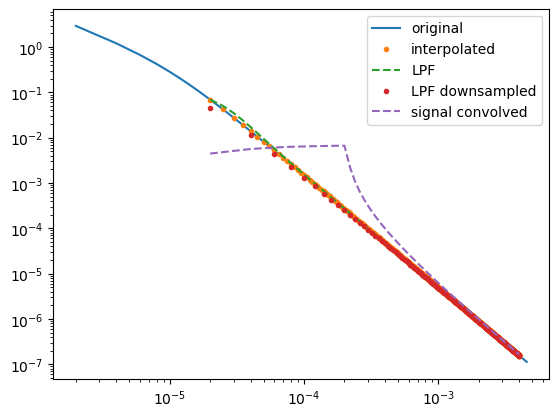

In [329]:
f_in  = 200e3        # 500 kHz
f_out = 50e3 #50e3         # 50 kHz
duration = tend
down = int(f_in / f_out)
n_in  = int(duration * f_in)
n_out = int(duration * f_out)
times_in  = 1/f_out  + np.linspace(0, duration, n_in,endpoint=False)  # 2e-6, 4e-6, ...
times_out = 1/f_out + np.linspace(0, duration, n_out,endpoint=False)  # 2e-5, 4e-5, ...

print(times_in.shape, times_out.shape)
print(times_in[:5], times_in[-5:])
print(times_out[:5], times_out[-5:])
# interpolator = interp1d(time_rec, dpred_ref)
interpolator = CubicSpline(time_rec, dpred_ref, extrapolate=False)
# interpolator = PchipInterpolator(time_rec, dpred_ref, extrapolate=False)
# interpolator = interp1d(time_rec, dpred_ref, kind='linear',
#                         bounds_error=False, fill_value="extrapolate")
dpred_ref_interp = interpolator(times_in)
# dpred_ref_LPF = resample_poly(dpred_ref_interp, up=1, down=10)
# dpred_ref_LPF = decimate(dpred_ref_interp, q=down, ftype='fir', zero_phase=True)
# dpred_ref_LPF = dpred_ref_interp
dpred_ref_LPF = apply_lowpass_fiilter_time(
    data= dpred_ref_interp, f_in=f_in, cutoff=f_out*0.5, order=1)
dpred_ref_LPF_down = downsample(dpred_ref_LPF, down=down)
dpred_ref_linrmp = signal.convolve(
    dpred_ref_LPF_down,filt_linrmp)[:len(dpred_ref_LPF_down)]

plt.loglog(time_rec, dpred_ref, label='original', linestyle="-")
plt.loglog(times_in, dpred_ref_interp, label='interpolated', linestyle="", marker=".")
plt.loglog(times_in, dpred_ref_LPF, label='LPF', linestyle="--")
plt.loglog(times_out, dpred_ref_LPF_down, label='LPF downsampled', linestyle="", marker=".")
plt.loglog(times_out, dpred_ref_linrmp, label='signal convolved', linestyle="--")
plt.legend()


In [350]:
f_in  = 200e3        # 500 kHz
f_out = smp_freq #50e3         # 50 kHz

WISTEM_SP_sim = TEM_Signal_Process (
    # base_freq=base_freq,
    # on_time=on_time, 
    rmp_time=rmp_time, 
    rec_time=tend, #+1/smp_freq, 
    smp_freq=  f_in #  smp_freq*4
)  
print(1/time_step_min)
times_sim = WISTEM_SP_sim.times_rec
print(time_rec[:5], time_rec[-5:])
print(times_sim[:5], times_sim[-5:])


WISTEM_SP_dpred = TEM_Signal_Process(
    rmp_time=rmp_time,
    rec_time=tend,
    smp_freq =f_out
)
print(smp_freq)
times_rec = WISTEM_SP_dpred.times_rec
times_filt = WISTEM_SP_dpred.times_filt
filt_linrmp = WISTEM_SP_dpred.filter_linear_rmp()
down=int(f_in / f_out)
# WISTEM_SP_sim.get_windows_cen(windows_cen=times_rec)
print(times_rec.size)
print(times_rec[:5])
print(down)
times_sim_shift = times_sim #[down-1:-1]

print(filt_linrmp.size)

500000.0
[2.e-06 4.e-06 6.e-06 8.e-06 1.e-05] [0.004348 0.004398 0.004448 0.004498 0.004548]
[5.0e-06 1.0e-05 1.5e-05 2.0e-05 2.5e-05] [0.00398  0.003985 0.00399  0.003995 0.004   ]
50000.0
200
[2.e-05 4.e-05 6.e-05 8.e-05 1.e-04]
4
200


In [351]:
dpred_ref_interp = WISTEM_SP_sim.interpolate_data(
    data=dpred_ref, times= time_rec,method='cubic'
 )
print(dpred_ref_interp.size)

dpred_ref_interp_LPF = WISTEM_SP_sim.apply_lowpass_filter(
    data=dpred_ref_interp, cutoff=smp_freq /2.0
)
dpred_ref_LPF_sim =dpred_ref_interp_LPF #[down-1:-1]
print(dpred_ref_LPF_sim.size)
# dpred_ref_LPF_sim = WISTEM_SP_sim.apply_lowpass_filter(
#     data=dpred_ref_interp_shift, cutoff=smp_freq /2.0
# )
print(dpred_ref_LPF_sim.size)
dpred_ref_LPF = downsample(dpred_ref_LPF_sim, down=down)
# dpred_ref_LPF = WISTEM_SP_sim.window(
#     data=dpred_ref_LPF_sim, times= times_sim
# )

# dpred_ref_LPF = resample_poly(dpred_ref_interp_shift, up=up, down=down)
print(dpred_ref_LPF.size)
dpred_ref_linrmp = signal.convolve(
    dpred_ref_LPF,filt_linrmp)[:len(dpred_ref_LPF)]
print(dpred_ref_linrmp.size)

800
800
800
200
200


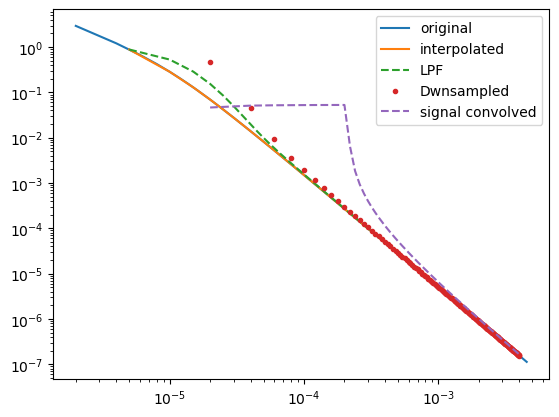

In [352]:
plt.loglog(time_rec, dpred_ref, label='original', linestyle="-")
plt.loglog(times_sim, dpred_ref_interp, label='interpolated', linestyle="-")
# plt.loglog(times_sim_shift, dpred_ref_interp_shift, label='time shifted', linestyle='--')
plt.loglog(times_sim_shift, dpred_ref_LPF_sim, label='LPF', linestyle='--')
plt.loglog(times_rec, dpred_ref_LPF, label='Dwnsampled', linestyle="", marker=".")
plt.loglog(times_rec, dpred_ref_linrmp, label='signal convolved', linestyle="--")
plt.legend()


In [353]:
dpred_interp = WISTEM_SP_sim.interpolate_data(
    data=dpred_vessel, times= time_rec,method='linear'
 )
print(dpred_interp.size)
dpred_interp_LPF = WISTEM_SP_sim.apply_lowpass_filter(
    data=dpred_interp, cutoff=smp_freq /2.0
)
dpred_vessel_LPF_sim =dpred_interp_LPF#[down-1:-1]
# print(dpred_interp_shift.size)
# dpred_vessel_LPF_sim = dpred_interp_shift
# dpred_vessel_LPF_sim = WISTEM_SP_sim.apply_lowpass_filter(
#     data=dpred_interp_shift, cutoff=smp_freq /2.0
# )
# dpred_vessel_LPF = WISTEM_SP_dpred.interpolate_data(
#     data=dpred_vessel_LPF_sim, times= times_sim, method='linear'
# )
dpred_vessel_LPF = downsample(dpred_vessel_LPF_sim, down=down)
# dpred_vessel_LPF = WISTEM_SP_sim.window(
#     data=dpred_vessel_LPF_sim, times=times_sim
# )
dpred_vessel_linrmp = signal.convolve(
    dpred_vessel_LPF,filt_linrmp)[:len(dpred_vessel_LPF)]

800


In [354]:
dpred_interp = WISTEM_SP_sim.interpolate_data(
    data=dpred_target, times= time_rec, method='linear'
 )
print(dpred_interp.size)
dpred_interp_LPF = WISTEM_SP_sim.apply_lowpass_filter(
    data=dpred_interp, cutoff=smp_freq /2.0
)
dpred_target_LPF_sim = dpred_interp_LPF#[down-1:-1]
# dpred_interp_shift =dpred_interp_LPF[down-1:-1]
# print(dpred_interp_shift.size)
# dpred_target_LPF_sim = dpred_interp_shift
# dpred_target_LPF_sim = WISTEM_SP_sim.apply_lowpass_filter(
#     data=dpred_interp_shift, cutoff=smp_freq /2.0
# )
# dpred_target_LPF = WISTEM_SP_dpred.interpolate_data(
#     data=dpred_target_LPF_sim, times= times_sim, method='linear'
# )
dpred_target_LPF = downsample(dpred_target_LPF_sim, down=down)
# dpred_target_LPF = WISTEM_SP_sim.window(
#     data= dpred_target_LPF_sim, times = times_sim
# )
print(dpred_target_LPF.size)
dpred_target_linrmp = signal.convolve(
    dpred_target_LPF,filt_linrmp)[:len(dpred_target_LPF)]

800
200


In [355]:
dpred_interp = WISTEM_SP_sim.interpolate_data(
    data=dpred_vessel_target,times= time_rec, method='linear'
 )
print(dpred_interp.size)
dpred_interp_LPF = WISTEM_SP_sim.apply_lowpass_filter(
    data=dpred_interp, cutoff=smp_freq /2.0
)
dpred_vessel_target_LPF_sim = dpred_interp_LPF#[down-1:-1]
print(dpred_vessel_target_LPF_sim.size)
# dpred_interp_shift =dpred_interp[down-1:-1]
# print(dpred_interp_shift.size)
# dpred_vessel_target_LPF_sim = dpred_interp_shift
# dpred_vessel_target_LPF_sim = WISTEM_SP_sim.apply_lowpass_filter(
#     data=dpred_interp_shift, cutoff=smp_freq/2.0
# )
# dpred_vessel_target_LPF = WISTEM_SP_dpred.interpolate_data(
#     data=dpred_vessel_target_LPF_sim, times= times_sim, method='linear'
# )
dpred_vessel_target_LPF=downsample(dpred_vessel_target_LPF_sim, down=down)
# dpred_vessel_target_LPF=WISTEM_SP_sim.window(
#     data=dpred_vessel_target_LPF_sim, times = times_sim
# )
dpred_vessel_target_linrmp = signal.convolve(
    dpred_vessel_target_LPF,filt_linrmp)[:len(dpred_vessel_target_LPF)]

800
800


In [356]:
dpred_interp = WISTEM_SP_sim.interpolate_data(
    data=dpred_IP,times= times_rec_simpegEMIP, method='linear'
 )
print(dpred_interp.size)
dpred_interp_LPF = WISTEM_SP_sim.apply_lowpass_filter(
    data=dpred_interp, cutoff=smp_freq /2.0
)
dpred_IP_LPF_sim = dpred_interp_LPF#[down-1:-1]
print(dpred_IP_LPF_sim.size)
# dpred_interp_shift =dpred_interp[down-1:-1]
# print(dpred_interp_shift.size)
# dpred_IP_LPF_sim = dpred_interp_shift
# dpred_IP_LPF_sim = WISTEM_SP_sim.apply_lowpass_filter(
#     data=dpred_interp_shift, cutoff=smp_freq/2.0
# )
# dpred_IP_LPF = WISTEM_SP_dpred.interpolate_data(
#     data=dpred_IP_LPF_sim, times= times_sim, method='linear'
# )   
dpred_IP_LPF = downsample(dpred_IP_LPF_sim, down=down)
# dpred_IP_LPF = WISTEM_SP_sim.window(
#     data= dpred_IP_LPF_sim, times= times_sim
# )
dpred_IP_linrmp = signal.convolve(
    dpred_IP_LPF,filt_linrmp)[:len(dpred_IP_LPF)]

800
800


In [357]:
dpred_interp = WISTEM_SP_sim.interpolate_data(
    data=dpred_IP_vessel,times= times_rec_simpegEMIP, method='linear'
 )
print(dpred_interp.size)
dpred_interp_LPF = WISTEM_SP_sim.apply_lowpass_filter(
    data=dpred_interp, cutoff=smp_freq /2.0
)
dpred_IP_vessel_LPF_sim = dpred_interp_LPF#[down-1:-1]
print(dpred_IP_vessel_LPF_sim.size)
# dpred_interp_shift =dpred_interp[down-1:-1]
# print(dpred_interp_shift.size)
# dpred_IP_vessel_LPF_sim = dpred_interp_shift
# dpred_IP_vessel_LPF_sim = WISTEM_SP_sim.apply_lowpass_filter(
#     data=dpred_interp_shift, cutoff=smp_freq/2.0
# )
# dpred_IP_vessel_LPF = WISTEM_SP_dpred.interpolate_data(
#     data=dpred_IP_vessel_LPF_sim, times= times_sim, method='linear'
# )   
dpred_IP_vessel_LPF=downsample(dpred_IP_vessel_LPF_sim, down=down)
# dpred_IP_vessel_LPF=WISTEM_SP_sim.window(
#     data=dpred_IP_vessel_LPF_sim, times=times_sim
# )
dpred_IP_vessel_linrmp = signal.convolve(
    dpred_IP_vessel_LPF,filt_linrmp)[:len(dpred_IP_vessel_LPF)]

800
800


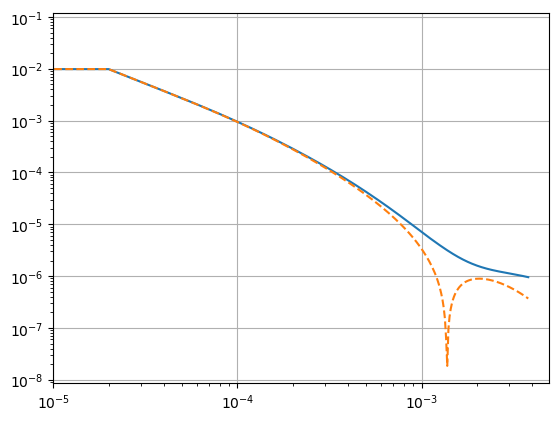

In [358]:
plt.loglog(times_rec-rmp_time,np.abs(dpred_IP_vessel_linrmp))
plt.loglog(times_rec-rmp_time,np.abs(dpred_IP_linrmp), linestyle='--')
plt.xlim(left=1e-5)
plt.grid()

# Plot

In [359]:
PL_decay = PsuedoLog(
    logmin=1e-7,
    linScale=0.5,
    logminx=1e-4,
    linScalex=0.5
    )
PL_filt = PsuedoLog(
    logmin=1e-6,
    linScale=0.5,
    logminx=1e-4,
    linScalex=0.5
    )

# Ratio

Text(0.5, 1.0, 'Ratio test for conductive model')

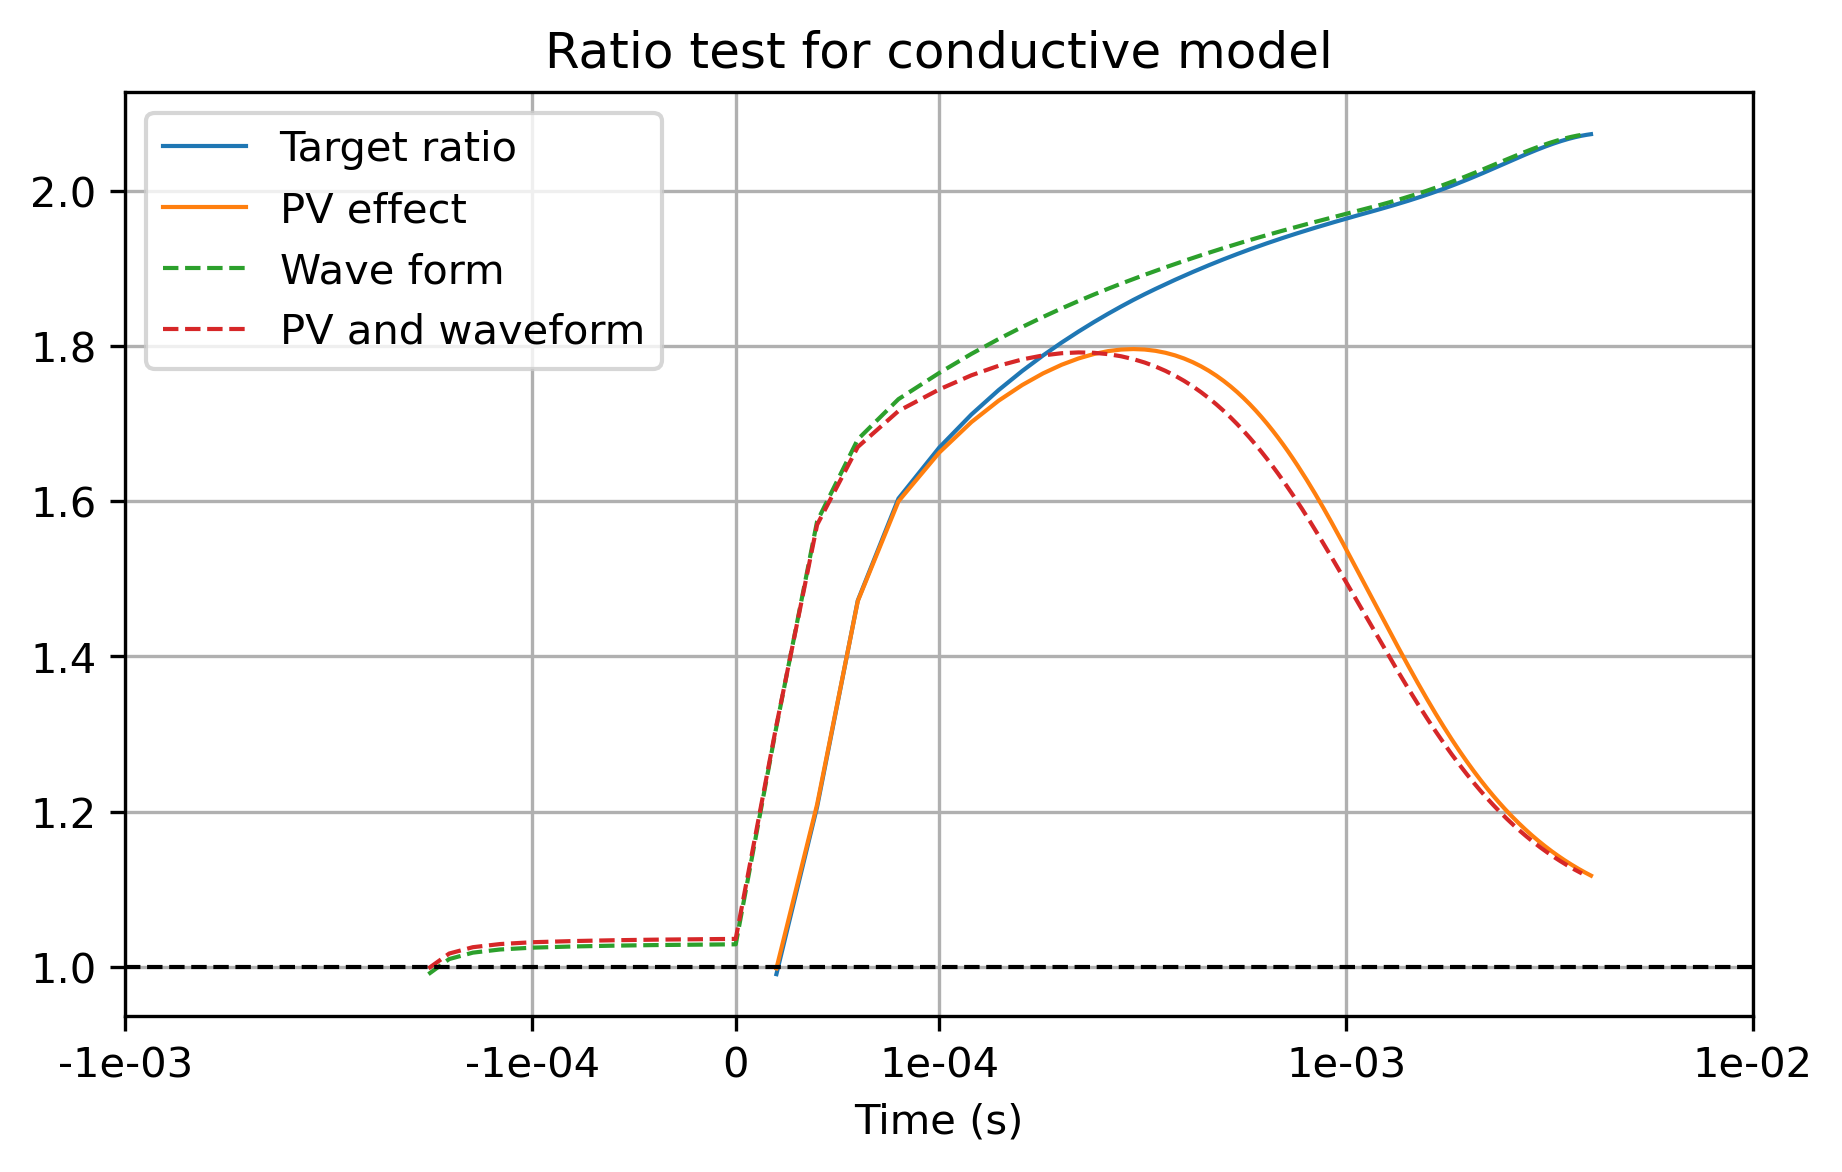

In [360]:
# Conductive model
fig, ax = plt.subplots(1, 1, figsize=(7,4),dpi=300)
#    ax.loglog(times_sim, dobs_ref, "k-", label="data of reference model")
off_time = 0
ax=PL_decay.semiplx(x=times_rec-off_time,y=dpred_target_LPF/dpred_ref_LPF,
   yscale_log=False, color="C0",label="Target ratio",ax=ax)
ax=PL_decay.semiplx(x=times_rec-off_time,y=dpred_vessel_target_LPF/ dpred_vessel_LPF,
   yscale_log=False, color="C1",label="PV effect",ax=ax)
off_time = rmp_time
ax=PL_decay.semiplx(x=times_rec-off_time,y=dpred_target_linrmp/dpred_ref_linrmp,
   yscale_log=False, linestyle="--",color="C2",label="Wave form",ax=ax)
ax=PL_decay.semiplx(x=times_rec-off_time,y=dpred_vessel_target_linrmp/ dpred_vessel_linrmp,
   yscale_log=False, linestyle="--", color="C3",label="PV and waveform",ax=ax)
plt.axhline( y=1.0, color="k", linewidth=1.0,linestyle="--")
PL_decay.pl_axes_x(ax=ax)
ax.legend()
ax.grid(True)
ax.set_xlabel("Time (s)")
ax.set_title("Ratio test for conductive model")

Text(0.5, 1.0, 'Ratio test for IP model')

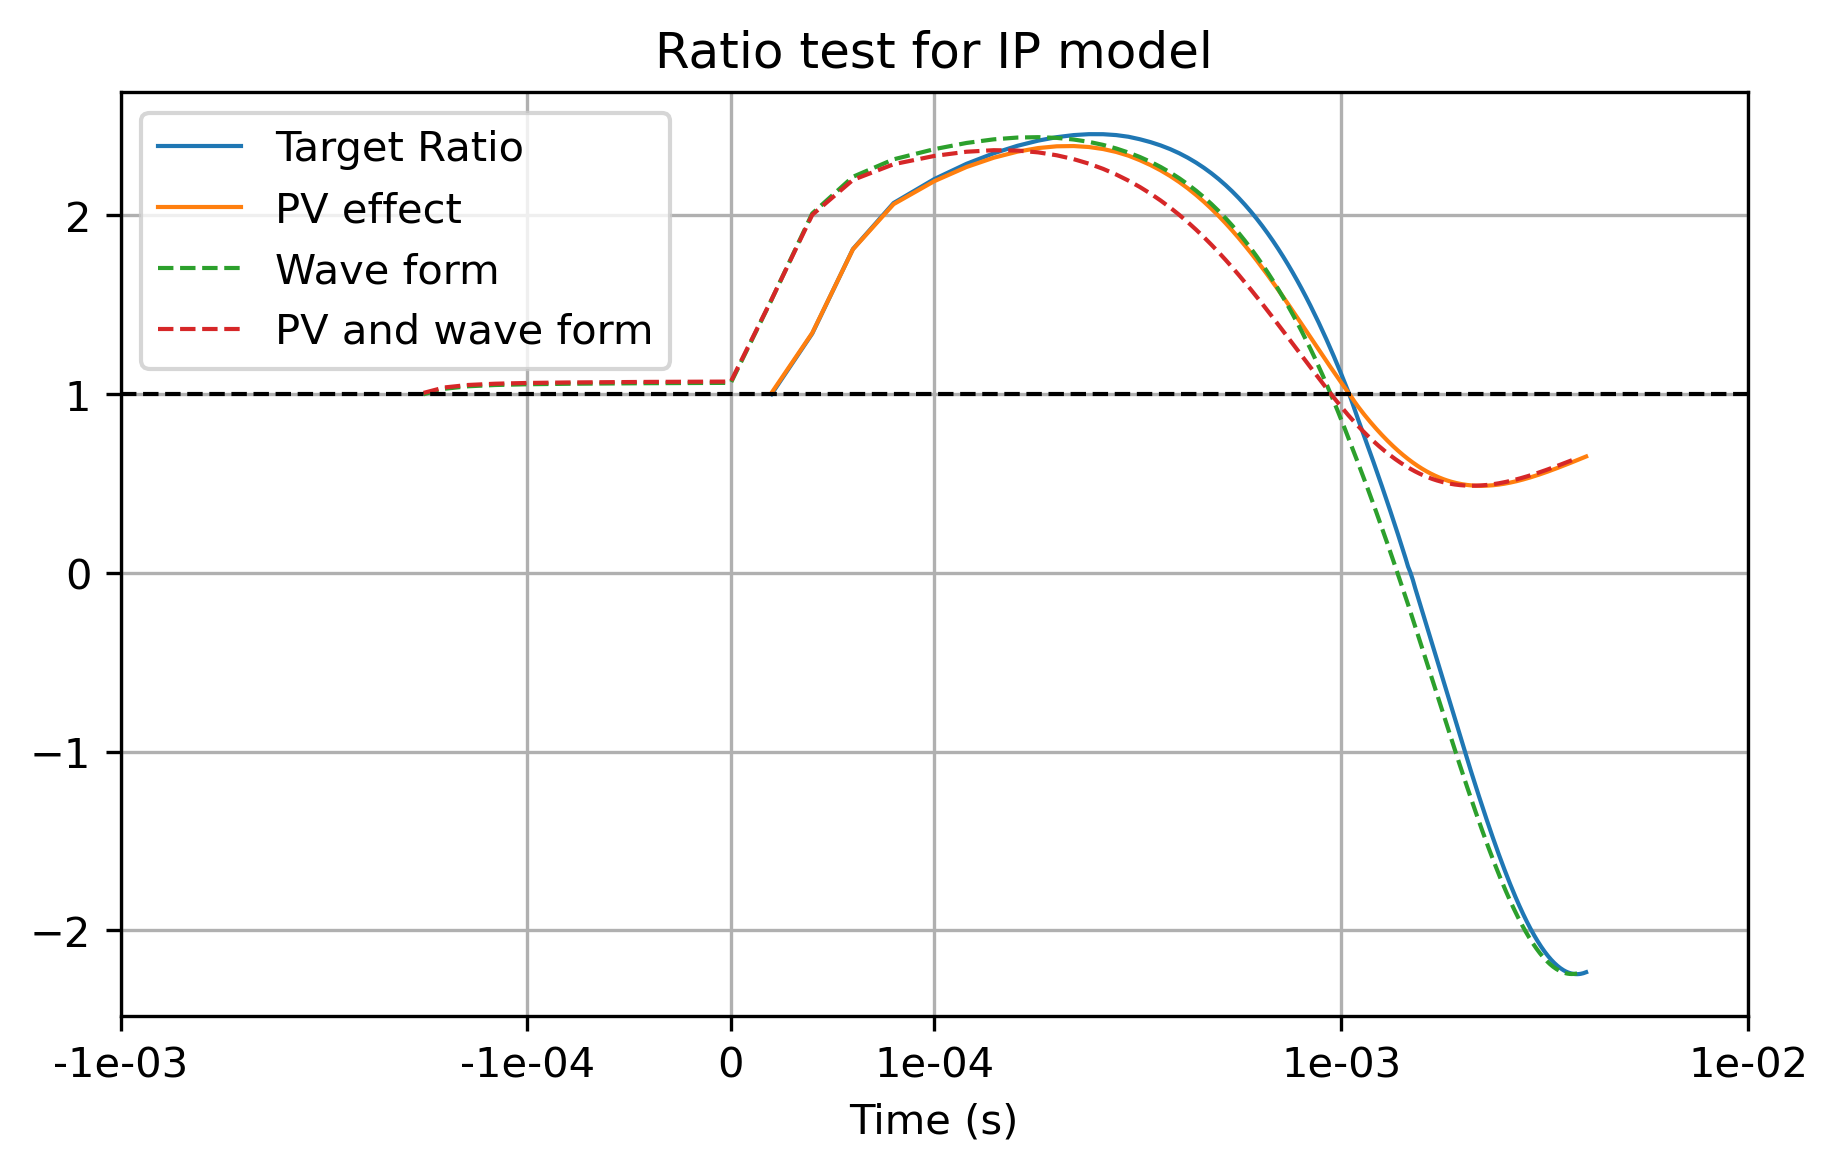

In [361]:
fig, ax = plt.subplots(1, 1, figsize=(7,4),dpi=300)
#    ax.loglog(times_sim, dobs_ref, "k-", label="data of reference model")
off_time = 0
ax=PL_decay.semiplx(x=times_rec-off_time,y=dpred_IP_LPF/dpred_ref_LPF,
   yscale_log=False, color="C0",label="Target Ratio",ax=ax)
ax=PL_decay.semiplx(x=times_rec-off_time,y=dpred_IP_vessel_LPF/ dpred_vessel_LPF,
   yscale_log=False, color="C1",label="PV effect",ax=ax)
off_time = rmp_time
ax=PL_decay.semiplx(x=times_rec-off_time,y=dpred_IP_linrmp/dpred_ref_linrmp,
   yscale_log=False, linestyle="--",color="C2",label="Wave form",ax=ax)
ax=PL_decay.semiplx(x=times_rec-off_time,y=dpred_IP_vessel_linrmp/ dpred_vessel_linrmp,
   yscale_log=False, linestyle="--",color="C3",label="PV and wave form",ax=ax)
plt.axhline( y=1.0, color="k", linewidth=1.0,linestyle="--")
PL_decay.pl_axes_x(ax=ax)
ax.legend()
ax.grid(True)
ax.set_xlabel("Time (s)")
ax.set_title("Ratio test for IP model")

## Deconvolution test

In [362]:
filt_decnv = WISTEM_SP_sim.deconvolve(
    data=dpred_ref_linrmp, data_pulse=dpred_ref_LPF)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.93889390e-18
  6.93889390e-18  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.16840434e-19 -1.08420217e-19  0.00000000e+00  0.00000000e+00
 -2.71050543e-20  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.35525272e-20  0.00000000e+00
  6.77626358e-21  0.00000000e+00 -6.77626358e-21 -6.77626358e-21
  0.00000000e+00  6.77626358e-21  0.00000000e+00 -3.38813179e-21
  0.00000000e+00 -3.38813179e-21 -3.38813179e-21 -3.38813179e-21
  3.38813179e-21  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.38813179e-21 -1.69406589e-21  0.00000000e+00  0.00000000e+00
  1.69406589e-21 -1.69406589e-21 -1.69406589e-21 -1.69406589e-21
 -1.69406589e-21 -8.47032947e-22  0.00000000e+00  0.00000000e+00
 -8.47032947e-22  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.23516474e-22 -8.47032

In [363]:
filt_decnv_sys = WISTEM_SP_sim.deconvolve(
    data=dpred_vessel_linrmp, data_pulse=dpred_ref_LPF)

[ 0.00000000e+00  0.00000000e+00  6.93889390e-18  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.93889390e-18  1.38777878e-17
  0.00000000e+00  6.93889390e-18  8.67361738e-19 -2.16840434e-19
  1.08420217e-19  1.08420217e-19  5.42101086e-20 -5.42101086e-20
  0.00000000e+00  2.71050543e-20  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.35525272e-20  1.35525272e-20  0.00000000e+00  0.00000000e+00
  6.77626358e-21  0.00000000e+00  6.77626358e-21  0.00000000e+00
  3.38813179e-21 -3.38813179e-21  0.00000000e+00  0.00000000e+00
  3.38813179e-21  3.38813179e-21  0.00000000e+00 -3.38813179e-21
  3.38813179e-21  0.00000000e+00  3.38813179e-21  1.69406589e-21
 -1.69406589e-21  0.00000000e+00  3.38813179e-21  0.00000000e+00
 -1.69406589e-21  0.00000000e+00  3.38813179e-21 -1.69406589e-21
 -5.08219768e-21  1.69406589e-21 -3.38813179e-21 -1.69406589e-21
 -1.69406589e-21  0.00000000e+00  0.00000000e+00 -1.69406589e-21
 -8.47032947e-22 -8.47032

Text(0.5, 1.0, 'Acquired filter and wave form')

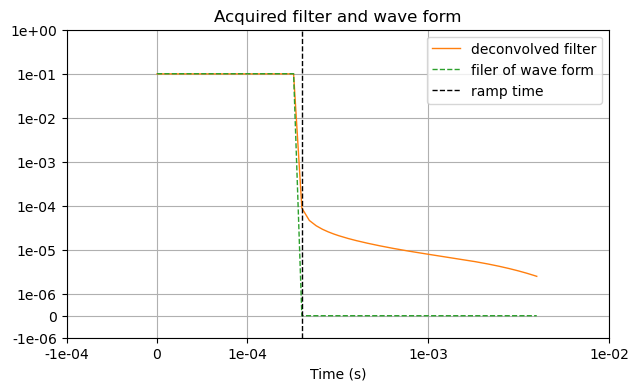

In [364]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))
#    ax.loglog(times_sim, dobs_ref, "k-", label="data of reference model")
ax =PL_filt.plpl_plot(x= times_filt, y=filt_decnv_sys,
    linestyle="-", color="C1",label="deconvolved filter",ax=ax)
ax =PL_filt.plpl_plot(x= times_filt, y=filt_linrmp ,
    linestyle="--", color="C2",label="filer of wave form",ax=ax)
PL_decay.pl_axvline(x=rmp_time, ax=ax, color="k",label="ramp time")
PL_filt.pl_axes(ax=ax)
PL_filt.pl_axes_x(ax=ax)

ax.legend()
ax.grid(True)
ax.set_xlabel("Time (s)")
ax.set_title("Acquired filter and wave form")
# plt.savefig('16_Filter.png', dpi=300)

# Convolve filter to target

In [365]:
dpred_target_filt = signal.convolve(
    dpred_target_LPF, filt_decnv_sys
    )[:len(dpred_target_LPF)]
dpred_IP_filt = signal.convolve(
    dpred_IP_LPF, filt_decnv_sys
    )[:len(dpred_IP_LPF)]

Text(0.5, 1.0, 'Simulation about conductive pressure Vessel impact')

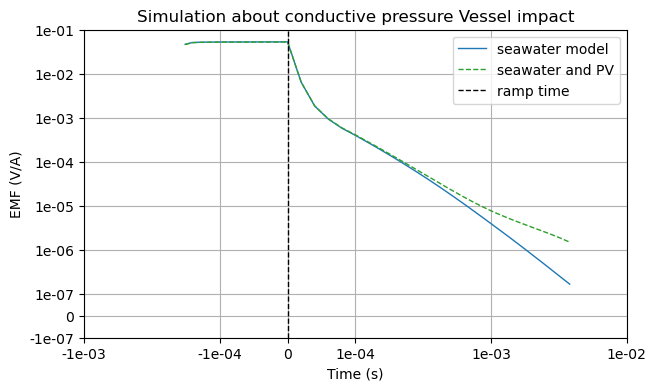

In [366]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_ref_linrmp, ax=ax
    , label='seawater model', linestyle='-', color='C0')
PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_vessel_linrmp, ax=ax
    , label='seawater and PV', linestyle='--', color='C2')
PL_decay.pl_axvline(x=0, ax=ax, color="k",label="ramp time")
PL_decay.pl_axes(ax=ax)
PL_decay.pl_axes_x(ax=ax)
ax.grid(True)
ax.legend()
ax.set_ylabel('EMF (V/A)')
ax.set_xlabel('Time (s)')
ax.set_title("Simulation about conductive pressure Vessel impact")
# plt.savefig('16_Sim_ref.png', dpi=300)

Text(0.5, 1.0, 'filter test about conductive model')

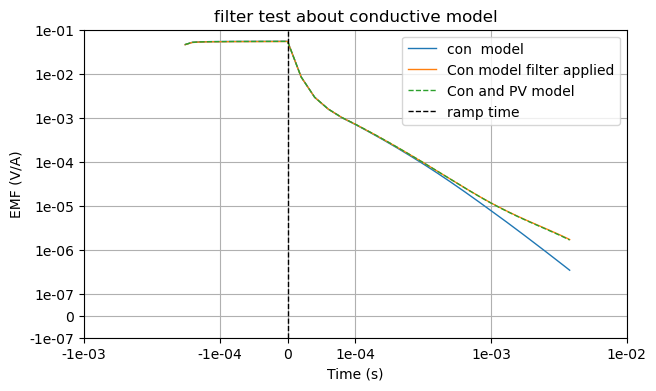

In [367]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_target_linrmp, ax=ax
    , label='con  model', linestyle='-', color='C0')
PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_target_filt, ax=ax
    , label='Con model filter applied', linestyle='-', color='C1')
PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_vessel_target_linrmp, ax=ax
    , label='Con and PV model', linestyle='--', color='C2')
PL_decay.pl_axvline(x=0, ax=ax, color="k",label="ramp time")
PL_decay.pl_axes(ax=ax)
PL_decay.pl_axes_x(ax=ax)
ax.grid(True)
ax.legend()
ax.set_ylabel('EMF (V/A)')
ax.set_xlabel('Time (s)')
ax.set_title("filter test about conductive model")
# plt.savefig('16_Sim_con.png', dpi=300)

Text(0.5, 1.0, 'filter test about IP model')

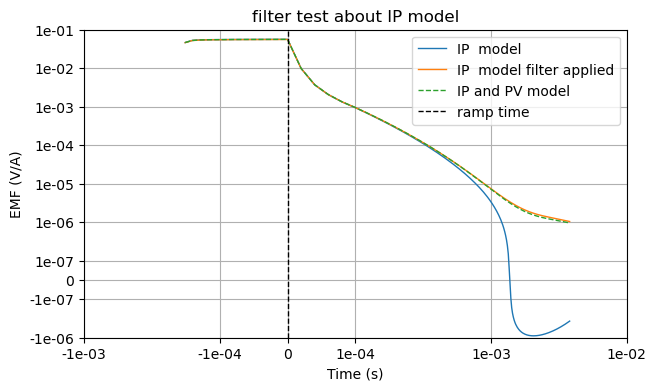

In [368]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_IP_linrmp, ax=ax
    , label='IP  model', linestyle='-', color='C0')
PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_IP_filt, ax=ax
    , label='IP  model filter applied', linestyle='-', color='C1')
PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_IP_vessel_linrmp, ax=ax
    , label='IP and PV model', linestyle='--', color='C2')

PL_decay.pl_axvline(x=0, ax=ax, color="k",label="ramp time")
PL_decay.pl_axes(ax=ax)
PL_decay.pl_axes_x(ax=ax)
ax.grid(True)
ax.legend()
ax.set_ylabel('EMF (V/A)')
ax.set_xlabel('Time (s)')
ax.set_title("filter test about IP model")
# plt.savefig('16_Sim_IP.png', dpi=300)

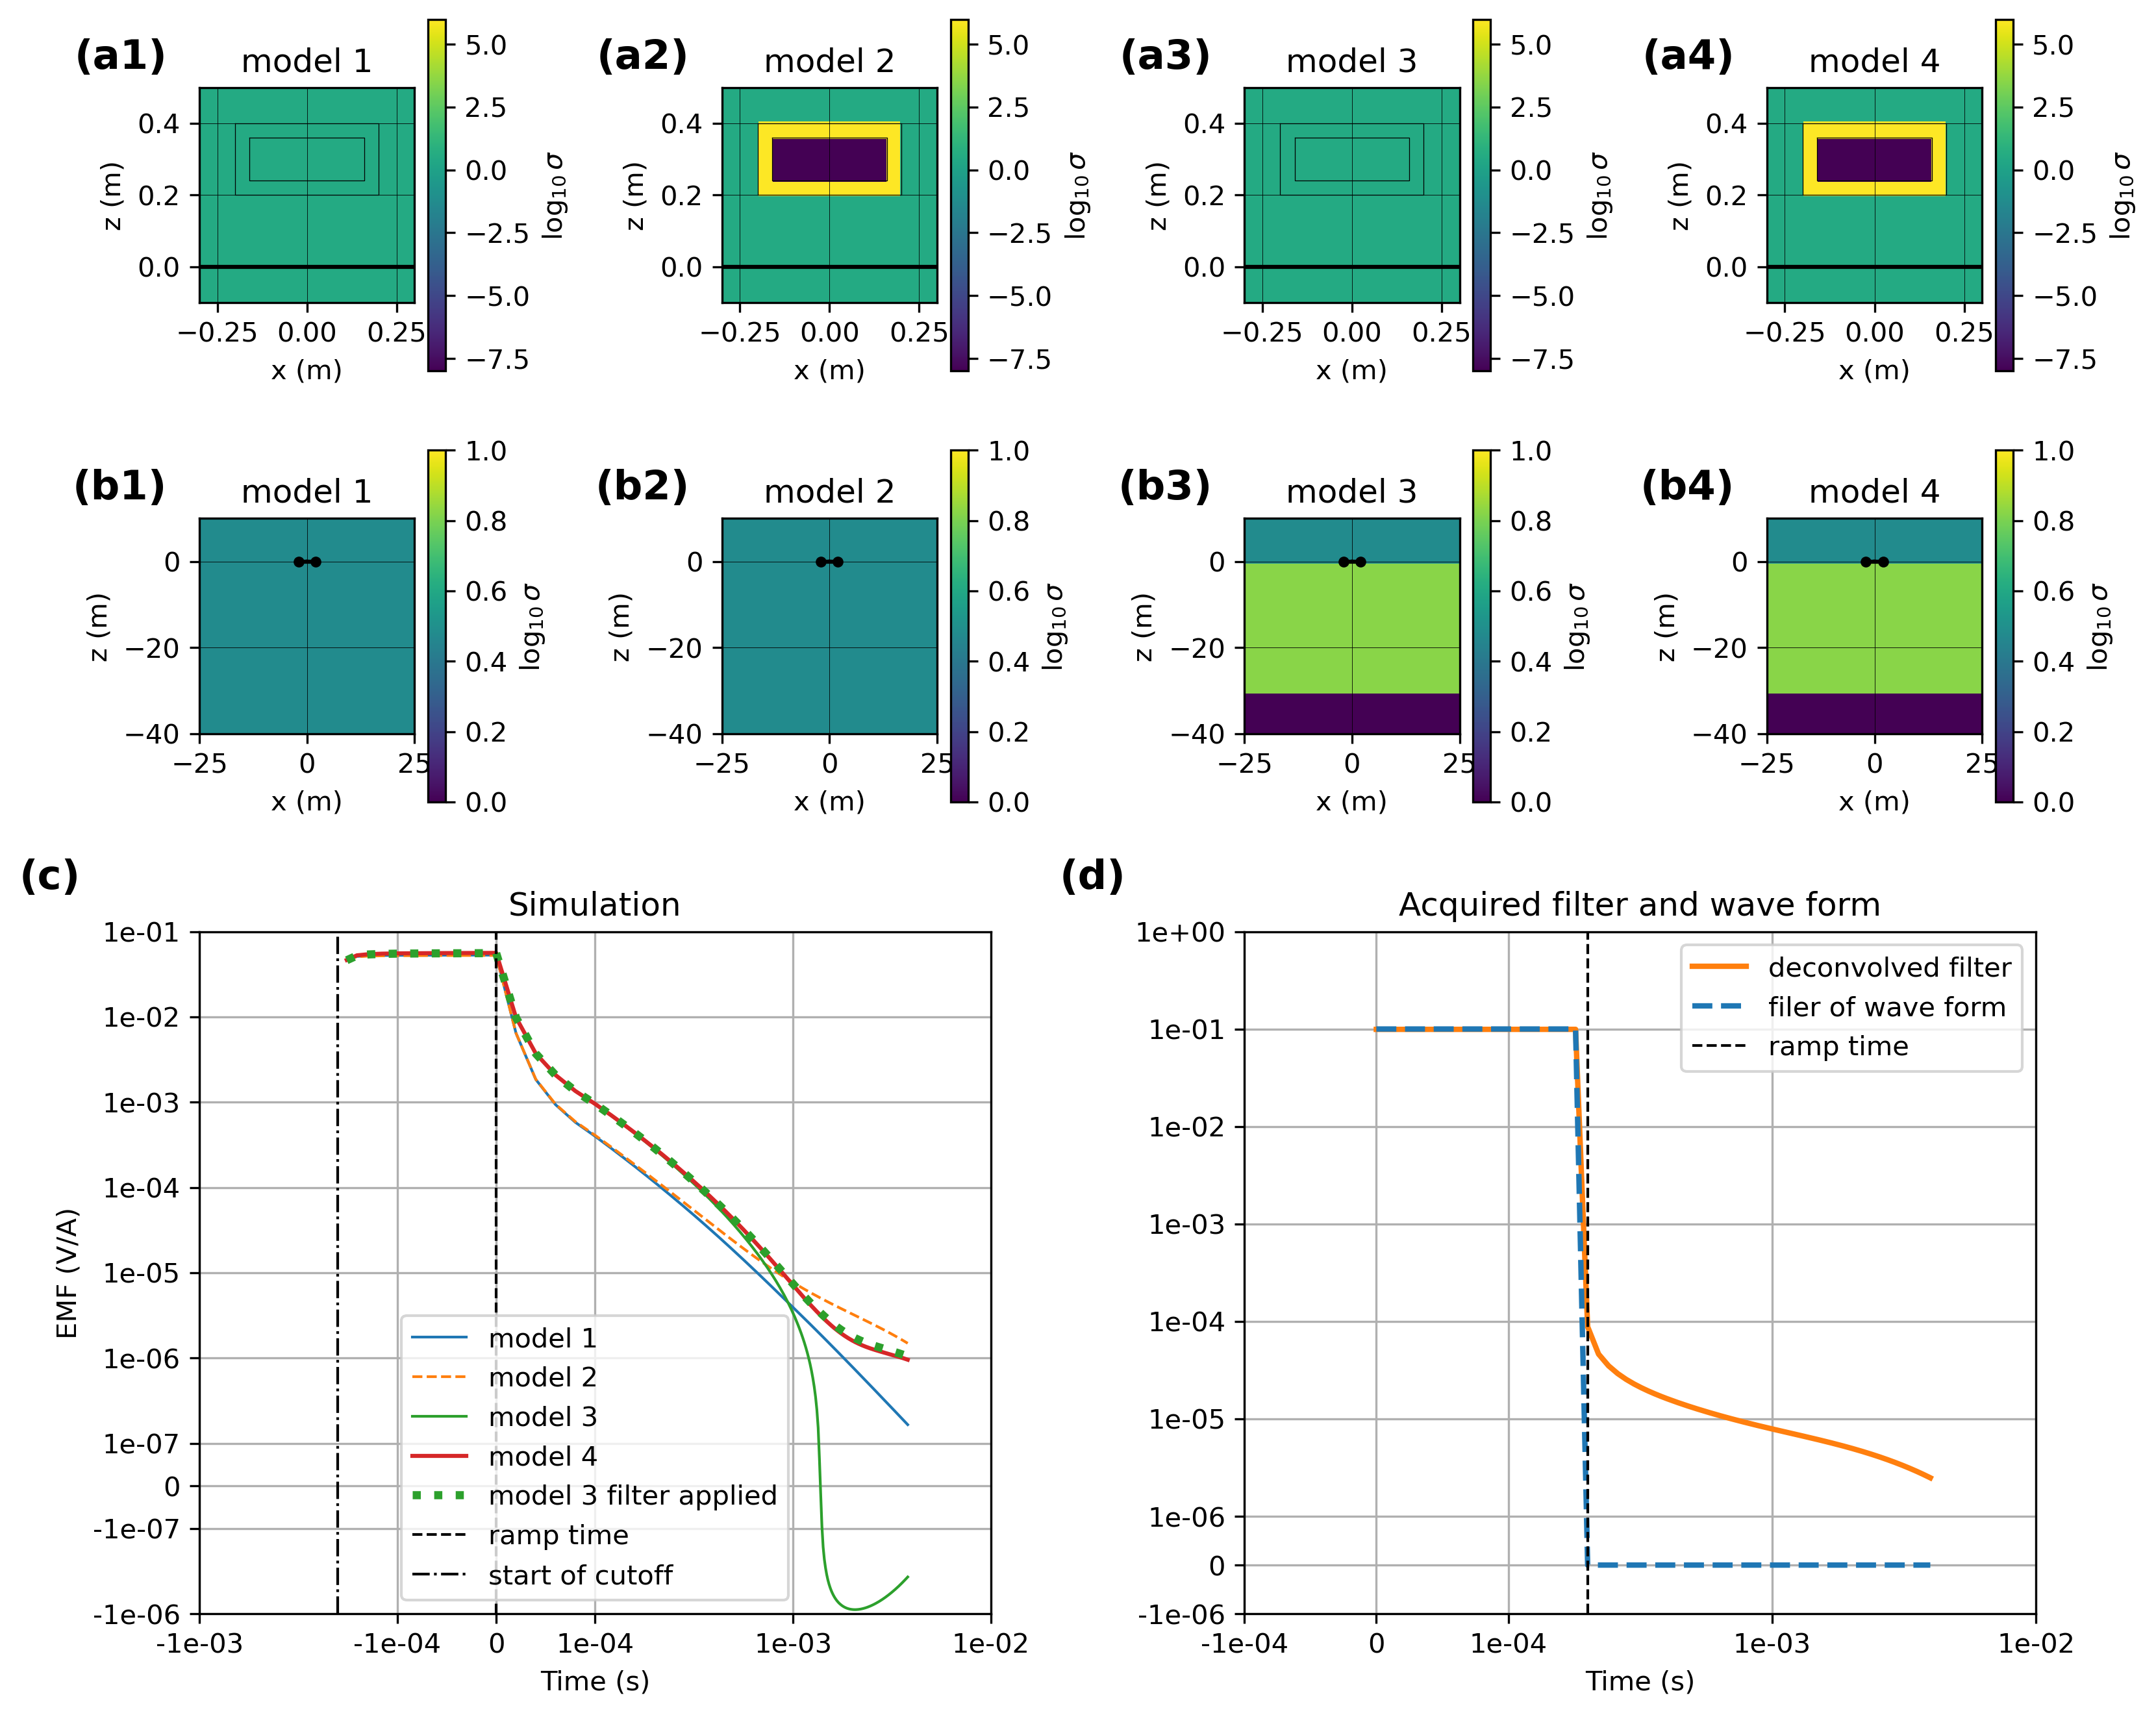

In [370]:
# for i in range(nrange):
dpi=300
fig = plt.figure(figsize=(11, 9), dpi=dpi)
gs = gridspec.GridSpec(4, 4)  
ax = [None] * 10

# Subplots
ax[0] = fig.add_subplot(gs[0, 0])
ax[1] = fig.add_subplot(gs[0, 1])
ax[2] = fig.add_subplot(gs[0, 2])
ax[3] = fig.add_subplot(gs[0, 3])
ax[4] = fig.add_subplot(gs[1, 0])
ax[5] = fig.add_subplot(gs[1, 1])
ax[6] = fig.add_subplot(gs[1, 2])
ax[7] = fig.add_subplot(gs[1, 3])
ax[8] = fig.add_subplot(gs[2:,:2])
ax[9] = fig.add_subplot(gs[2:,2:])
titles = ['model 1', 'model 2', 'model 3', 'model 4']

ax_vessel = [ax[0], ax[1], ax[2], ax[3]]
xlim, ylim = [-0.3, 0.3], [-0.1,0.5]
clim=[-8,6]
ax_vessel[0]=plot_model(model= model_ref, xlim=xlim,ylim=ylim,clim=clim, ax=ax_vessel[0])
ax_vessel[1]=plot_model(model= model_vessel, xlim=xlim,ylim=ylim,clim=clim, ax=ax_vessel[1])
ax_vessel[2]=plot_model(model= model_target, xlim=xlim,ylim=ylim,clim=clim,ax=ax_vessel[2])
ax_vessel[3]=plot_model(model= model_vessel_target, xlim=xlim,ylim=ylim,clim=clim, ax=ax_vessel[3])
for i, a in enumerate(ax_vessel):
    plot_vessel_outline(ax=a)
    a.set_title(titles[i])

ax_layer = [ax[4], ax[5], ax[6], ax[7]]
xlim, ylim = [-25, 25], [-40,10]
clim=[0,1]
ax_layer[0]=plot_model(model= model_ref, xlim=xlim,ylim=ylim,clim=clim, ax=ax_layer[0])
ax_layer[1]=plot_model(model= model_vessel, xlim=xlim,ylim=ylim,clim=clim, ax=ax_layer[1])
ax_layer[2]=plot_model(model= model_target, xlim=xlim,ylim=ylim,clim=clim,ax=ax_layer[2])
ax_layer[3]=plot_model(model= model_vessel_target, xlim=xlim,ylim=ylim,clim=clim, ax=ax_layer[3])
for i, a in enumerate(ax_layer):
    plot_vessel_outline(ax=a)
    a.set_title(titles[i])

ax[8]=PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_ref_linrmp, ax=ax[8]
    , label='model 1', linestyle='-', color='C0')
ax[8]=PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_vessel_linrmp, ax=ax[8]
    , label='model 2', linestyle='--', color='C1')
ax[8]=PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_IP_linrmp, ax=ax[8]
    , label='model 3', linestyle='-', color='C2')
ax[8]=PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_IP_vessel_linrmp, ax=ax[8]
    , label='model 4', linestyle='-', linewidth= 1.5,color='C3')
ax[8]=PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_IP_filt, ax=ax[8]
    , label='model 3 filter applied', linestyle=':', linewidth=3.0,color='C2')
# ax[8]=PL_decay.plpl_plot(x=times_rec-rmp_time, y=dpred_vessel_target_linrmp, ax=ax[8]
#     , label='model 4', linestyle='', marker='o', markersize=4.0, color='C5')
PL_decay.pl_axvline(x=0, ax=ax[8], color="k",label="ramp time")
PL_decay.pl_axvline(x=-rmp_time, ax=ax[8], color="k",
                    linestyle='-.', label="start of cutoff")
PL_decay.pl_axes(ax=ax[8])
PL_decay.pl_axes_x(ax=ax[8])
ax[8].grid(True)
ax[8].legend()
ax[8].set_ylabel('EMF (V/A)')
ax[8].set_xlabel('Time (s)')
ax[8].set_title("Simulation")

ax[9] =PL_filt.plpl_plot(x= times_filt, y=filt_decnv_sys,
    linestyle="-", linewidth=2.0,color="C1",label="deconvolved filter",ax=ax[9])
ax[9] =PL_filt.plpl_plot(x= times_filt, y=filt_linrmp ,
    linestyle="--",linewidth=2.0,color="C0",label="filer of wave form",ax=ax[9])
PL_decay.pl_axvline(x=rmp_time, ax=ax[9], color="k",label="ramp time")
PL_filt.pl_axes(ax=ax[9])
PL_filt.pl_axes_x(ax=ax[9])
ax[9].set_xlabel("Time (s)")
ax[9].legend()
ax[9].grid(True)    
ax[9].set_title("Acquired filter and wave form")

panel_labels = ['(a1)', '(a2)', '(a3)', '(a4)',
                '(b1)', '(b2)', '(b3)', '(b4)', '(c)', '(d)']

for label, axis in zip(panel_labels, ax):
    axis.text(
        -0.15, 1.05, label,
        transform=axis.transAxes,
        fontsize=15, fontweight='bold',
        va='bottom', ha='right'
    )
plt.tight_layout()
plt.savefig('72_Sim_PV.jpg', dpi=dpi)